# Aggregate Stock Sentiment & Market Direction

Does aggregate sentiment from tweets predict overall market direction (eg. SPY returns)?

In [1]:
import pandas as pd
import numpy as np

### Getting data for sentiment and SPY movement

Aggregate Daily Sentiment over all tweets and stocks.

In [2]:
tweets = pd.read_csv('../tweets-data/stock_tweets_out.csv', parse_dates=['Date'])
tweets['Date'] = tweets['Date'].dt.date # only interested in specific day
tweets['Sentiment'] = tweets['positive'] - tweets['negative'] # compute scalar sentiment value per tweet

# compute overall daily sentiment
daily_sentiment = tweets.groupby('Date')['Sentiment'].mean().reset_index()

# rolling averages
daily_sentiment['3-day'] = daily_sentiment['Sentiment'].rolling(3).mean()
daily_sentiment['5-day'] = daily_sentiment['Sentiment'].rolling(5).mean()

In [3]:
counts = tweets.groupby(['Date', 'Stock Name']).size().reset_index(name='TweetVolume')
print(counts['TweetVolume'].describe())

count    5910.000000
mean       13.670558
std        29.442641
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       462.000000
Name: TweetVolume, dtype: float64


In [4]:
daily_sentiment.head()

,Date,Sentiment,3-day,5-day
0,2021-09-30,0.310846,NaN,NaN
1,2021-10-01,0.310880,NaN,NaN
2,2021-10-02,0.419374,0.347033,NaN
3,2021-10-03,0.334475,0.354910,NaN
4,2021-10-04,0.019805,0.257885,0.279076


In [5]:
# Debug: check how different volume-weighted sentiment is from unweighted
# First compute unweighted just for comparison
simple_avg = tweets.groupby('Date')['Sentiment'].mean().reset_index(name='SimpleAvg')

# Compare
comparison = pd.merge(daily_sentiment, simple_avg, on='Date')
comparison['Difference'] = comparison['Sentiment'] - comparison['SimpleAvg']
print(comparison[['Date', 'Sentiment', 'SimpleAvg', 'Difference']].head(10))


         Date  Sentiment  SimpleAvg  Difference
0  2021-09-30   0.310846   0.310846         0.0
1  2021-10-01   0.310880   0.310880         0.0
2  2021-10-02   0.419374   0.419374         0.0
3  2021-10-03   0.334475   0.334475         0.0
4  2021-10-04   0.019805   0.019805         0.0
5  2021-10-05   0.108379   0.108379         0.0
6  2021-10-06   0.234439   0.234439         0.0
7  2021-10-07   0.305370   0.305370         0.0
8  2021-10-08   0.250751   0.250751         0.0
9  2021-10-09   0.236714   0.236714         0.0


Prepare SPY return & direction

In [6]:
spy = pd.read_csv('../stock-data/SPY.csv', skiprows=[1, 2])
spy.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
spy['Date'] = pd.to_datetime(spy['Date']).dt.date

spy['Return'] = spy['Close'].pct_change() # Compute returns
spy['Direction'] = (spy['Return'] > 0).astype(int) # Create label for binary direction

# Drop first row, because return will be NaN
spy = spy.dropna(subset=['Return'])

spy = spy[['Date', 'Return', 'Direction']]

In [7]:
spy

,Date,Return,Direction
1,2021-10-01,0.011884,1
2,2021-10-04,-0.012896,0
3,2021-10-05,0.010405,1
4,2021-10-06,0.004156,1
5,2021-10-07,0.008646,1
...,...,...,...
247,2022-09-23,-0.016755,0
248,2022-09-26,-0.009893,0
249,2022-09-27,-0.002553,0
250,2022-09-28,0.019676,1


Merge sentiment with SPY data

In [8]:
merged = pd.merge(spy, daily_sentiment, on='Date', how='inner')

In [9]:
merged

,Date,Return,Direction,Sentiment,3-day,5-day
0,2021-10-01,0.011884,1,0.310880,NaN,NaN
1,2021-10-04,-0.012896,0,0.019805,0.257885,0.279076
2,2021-10-05,0.010405,1,0.108379,0.154220,0.238583
3,2021-10-06,0.004156,1,0.234439,0.120874,0.223295
4,2021-10-07,0.008646,1,0.305370,0.216062,0.200494
...,...,...,...,...,...,...
246,2022-09-23,-0.016755,0,0.239017,0.224488,0.220510
247,2022-09-26,-0.009893,0,0.204958,0.248042,0.243523
248,2022-09-27,-0.002553,0,0.243141,0.214644,0.245257
249,2022-09-28,0.019676,1,0.215326,0.221142,0.240519


### Analysis

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import pearsonr

In [11]:
results = []

for col in ['Sentiment', '3-day', '5-day']:
    df = merged.dropna(subset=[col, 'Return', 'Direction'])
    
    # 3.1 Pearson Correlation
    corr, p_val = pearsonr(df[col], df['Return'])
    
    # 3.2 Lienar Regression
    lin_model = LinearRegression()
    lin_model.fit(df[[col]], df['Return'])
    beta_lin = lin_model.coef_[0]
    alpha_lin = lin_model.intercept_
    
    # 3.3 Logistic Regression
    log_model = LogisticRegression()
    log_model.fit(df[[col]], df['Direction'])
    beta_log = log_model.coef_[0][0]
    alpha_log = log_model.intercept_[0]
    
    preds = log_model.predict(df[[col]])
    probs = log_model.predict_proba(df[[col]])[:,1]
    acc = accuracy_score(df['Direction'], preds)
    auc = roc_auc_score(df['Direction'], probs)
    
    # store everything
    results.append({
        "Sentiment_Window": col,
        "Correlation_r": corr,
        "Correlation_p": p_val,
        "Linear_Beta": beta_lin,
        "Linear_Intercept": alpha_lin,
        "Logistic_Beta": beta_log,
        "Logistic_Intercept": alpha_log,
        "Accuracy": acc,
        "AUC": auc
    })
    
results_df = pd.DataFrame(results)

In [12]:
results_df

,Sentiment_Window,Correlation_r,Correlation_p,Linear_Beta,Linear_Intercept,Logistic_Beta,Logistic_Intercept,Accuracy,AUC
0,Sentiment,0.299356,0.000001,0.051431,-0.012174,1.417425,-0.361369,0.545817,0.601944
1,3-day,0.088005,0.165381,0.020213,-0.005264,0.291624,-0.115944,0.516000,0.528753
2,5-day,0.090318,0.154500,0.023429,-0.006143,0.269796,-0.112304,0.512000,0.529073


In [13]:
results_df.to_csv('market_direction_results', index=False)

In [14]:
results_df.to_markdown(index=False)

'| Sentiment_Window   |   Correlation_r |   Correlation_p |   Linear_Beta |   Linear_Intercept |   Logistic_Beta |   Logistic_Intercept |   Accuracy |      AUC |\n|:-------------------|----------------:|----------------:|--------------:|-------------------:|----------------:|---------------------:|-----------:|---------:|\n| Sentiment          |       0.299356  |     1.36364e-06 |     0.0514315 |        -0.0121737  |        1.41742  |            -0.361369 |   0.545817 | 0.601944 |\n| 3-day              |       0.088005  |     0.165381    |     0.0202131 |        -0.00526394 |        0.291624 |            -0.115944 |   0.516    | 0.528753 |\n| 5-day              |       0.0903185 |     0.1545      |     0.023429  |        -0.00614271 |        0.269796 |            -0.112304 |   0.512    | 0.529073 |'

## Graphs

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

Scatterplot of daily sentiment compared with return

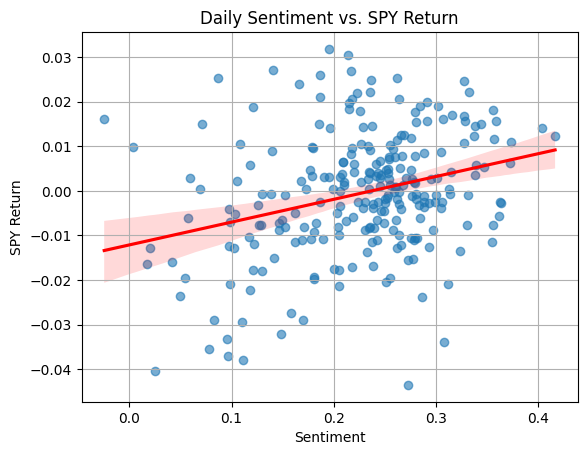

In [17]:
sns.regplot(data=df, x='Sentiment', y='Return', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Daily Sentiment vs. SPY Return')
plt.xlabel('Sentiment')
plt.ylabel('SPY Return')
plt.grid(True)
plt.savefig('daily_sentiment_return_scatterplot')

Time series line graph of sentiment windows compared with SPY return

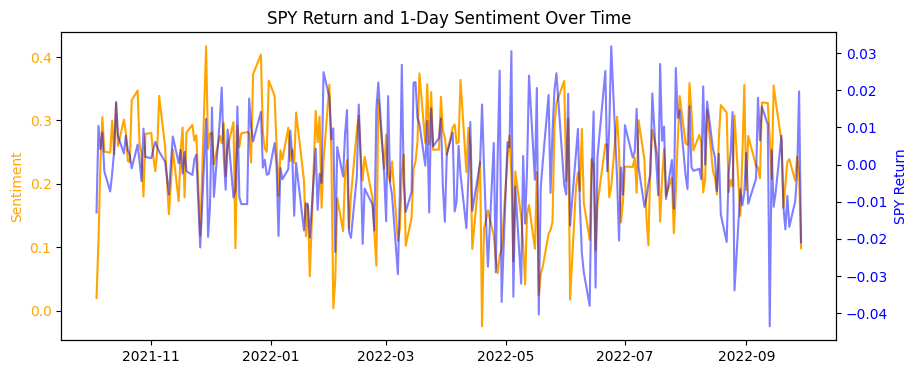

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax2 = ax1.twinx()
ax1.plot(df['Date'], df['Sentiment'], color='orange', label='1-day Sentiment')
ax2.plot(df['Date'], df['Return'], color='blue', alpha=0.5, label='SPY Return')

ax1.set_ylabel('Sentiment', color='orange')
ax2.set_ylabel('SPY Return', color='blue')
ax1.tick_params(axis='y', labelcolor='orange')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('SPY Return and 1-Day Sentiment Over Time')

plt.savefig('1day_sentiment_return_line')

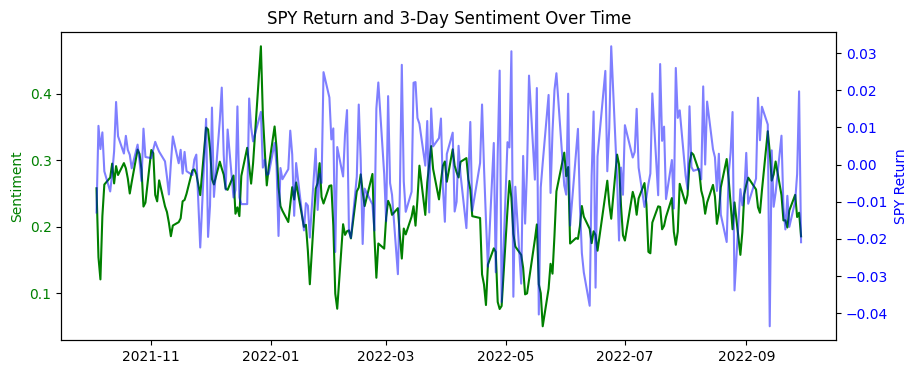

In [27]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax2 = ax1.twinx()
ax1.plot(df['Date'], df['3-day'], color='green', label='3-day Sentiment')
ax2.plot(df['Date'], df['Return'], color='blue', alpha=0.5, label='SPY Return')

ax1.set_ylabel('Sentiment', color='green')
ax2.set_ylabel('SPY Return', color='blue')
ax1.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('SPY Return and 3-Day Sentiment Over Time')

plt.savefig('3day_sentiment_return_line')

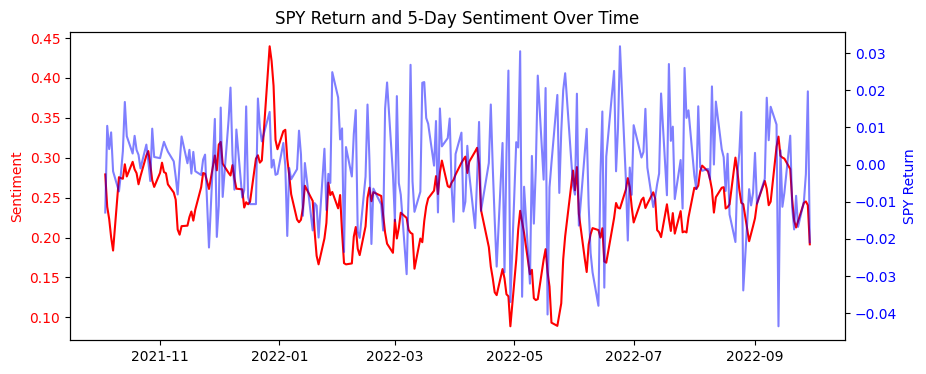

In [28]:
fig, ax1 = plt.subplots(figsize=(10, 4))

ax2 = ax1.twinx()
ax1.plot(df['Date'], df['5-day'], color='red', label='5-day Sentiment')
ax2.plot(df['Date'], df['Return'], color='blue', alpha=0.5, label='SPY Return')

ax1.set_ylabel('Sentiment', color='red')
ax2.set_ylabel('SPY Return', color='blue')
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_title('SPY Return and 5-Day Sentiment Over Time')

plt.savefig('5day_sentiment_return_line')